# Main Notebook: CV Series Workshop 2: Convolutional Neural Networks (CNNs)

## Table of Contents
<div class="alert alert-block alert-info">
<ol>
    <li>
      <a href="#scrollTo=Setup">Setup</a>
    </li>
    <li>
      <a href="#scrollTo=The_Disadvantanges_of_MLPs">The Disadvantanges of MLPs</a>
    <li>
      <a href="#scrollTo=Building_the_Model">Building the Model</a>
    </li>
    <li>
      <a href="#scrollTo=Training_the_Model">Training the Model</a>
    </li>
    <li><a href="#scrollTo=Conclusion">Conclusion</a></li>
</ol>
</div>

Conventions used:

❗ - Required <br>
❓ - Question <br>

Credit to these wonderful resources which we used as a basis for this workshop: 

* https://keras.io/examples/nlp/lstm_seq2seq/
* https://medium.com/analytics-vidhya/encoder-decoder-seq2seq-models-clearly-explained-c34186fbf49b
* https://www.analyticsvidhya.com/blog/2020/08/a-simple-introduction-to-sequence-to-sequence-models/#:~:text=Sequence%20to%20Sequence%20

# 1. Setup

The dataset we'll use is from this Kaggle MNIST competition. https://www.kaggle.com/competitions/digit-recognizer/data

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import Libraries

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

Initialize Variables

In [ ]:
args={}
kwargs={}
args['batch_size']=1000 #number of data points processed before you update the model again
args['test_batch_size']=1000 #number of data points tested before computing the model's loss
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10



Download Dataset

In [ ]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# 2. The Disadvantanges of MLPs

❓ Why have we decided to use a CNN model to recognize our numbers today instead of the MLP we used last week?

> MLP does not take into account spatial information of an image
- It does not understand how different parts of the images are connected to each other, which does not allow it to process more complex images such as shifted ones

# 3. Building the Model

## a. What is a Convolutional Neural Network (CNN)?

#### Convolutional Neural Networks capture and process images in a manner similar to how vision works --

#### They encode spatial information by combining different parts of the image in a process called "convolution."


## b. Overview of CNN Architecture

There can be various ways to implement extremely large and complex convolutional neural networks. In this workshop, we'll present a CNN model with some key parts that are commonly used.

#### In the MNIST dataset, the core of the CNN includes:

#### 1. Convolutional 2D Layers
#### 2. Max Pooling Layers
#### 3. ReLU Layers
#### 4. Dropout Layers
#### 5. Fully Connected (MLP) Layers
#### 6. Softmax

### Convolutional layers:
- A layer with a learnable "weight" filter that is multiplied with equal sized portions of the input, effectively making a convolution of the original input.
- First two arguments are the number of input and output channels and kernel size.
- The input is a tensor (in this case think of a 3d matrix).

❓ What is a kernel?

> The kernel is the filter (generally smaller than the input) that moves across and is dot product with the sub-region of the input matrix/tensor to compute the output matrix/tensor values.

❓ What is a tensor?

> If we think of vectors as 1d representations and matrices as 2d representations, then tensors are an N-d generalization.

In [ ]:
nn.Conv2d(1, 10, kernel_size=5)

Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))

### ReLU Layers:
- An activation function
- If input value is greater than 0, then return the input value. If input is less than or equal to 0, then return 0.

❓ What is an activation function?

> They are functions that perform a non-linear transformation to the input and usually ensure the output is within some desired range (like 0 to infinity or -1 to 1 or 0 to 1).

In [ ]:
F.relu

<function torch.nn.functional.relu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>

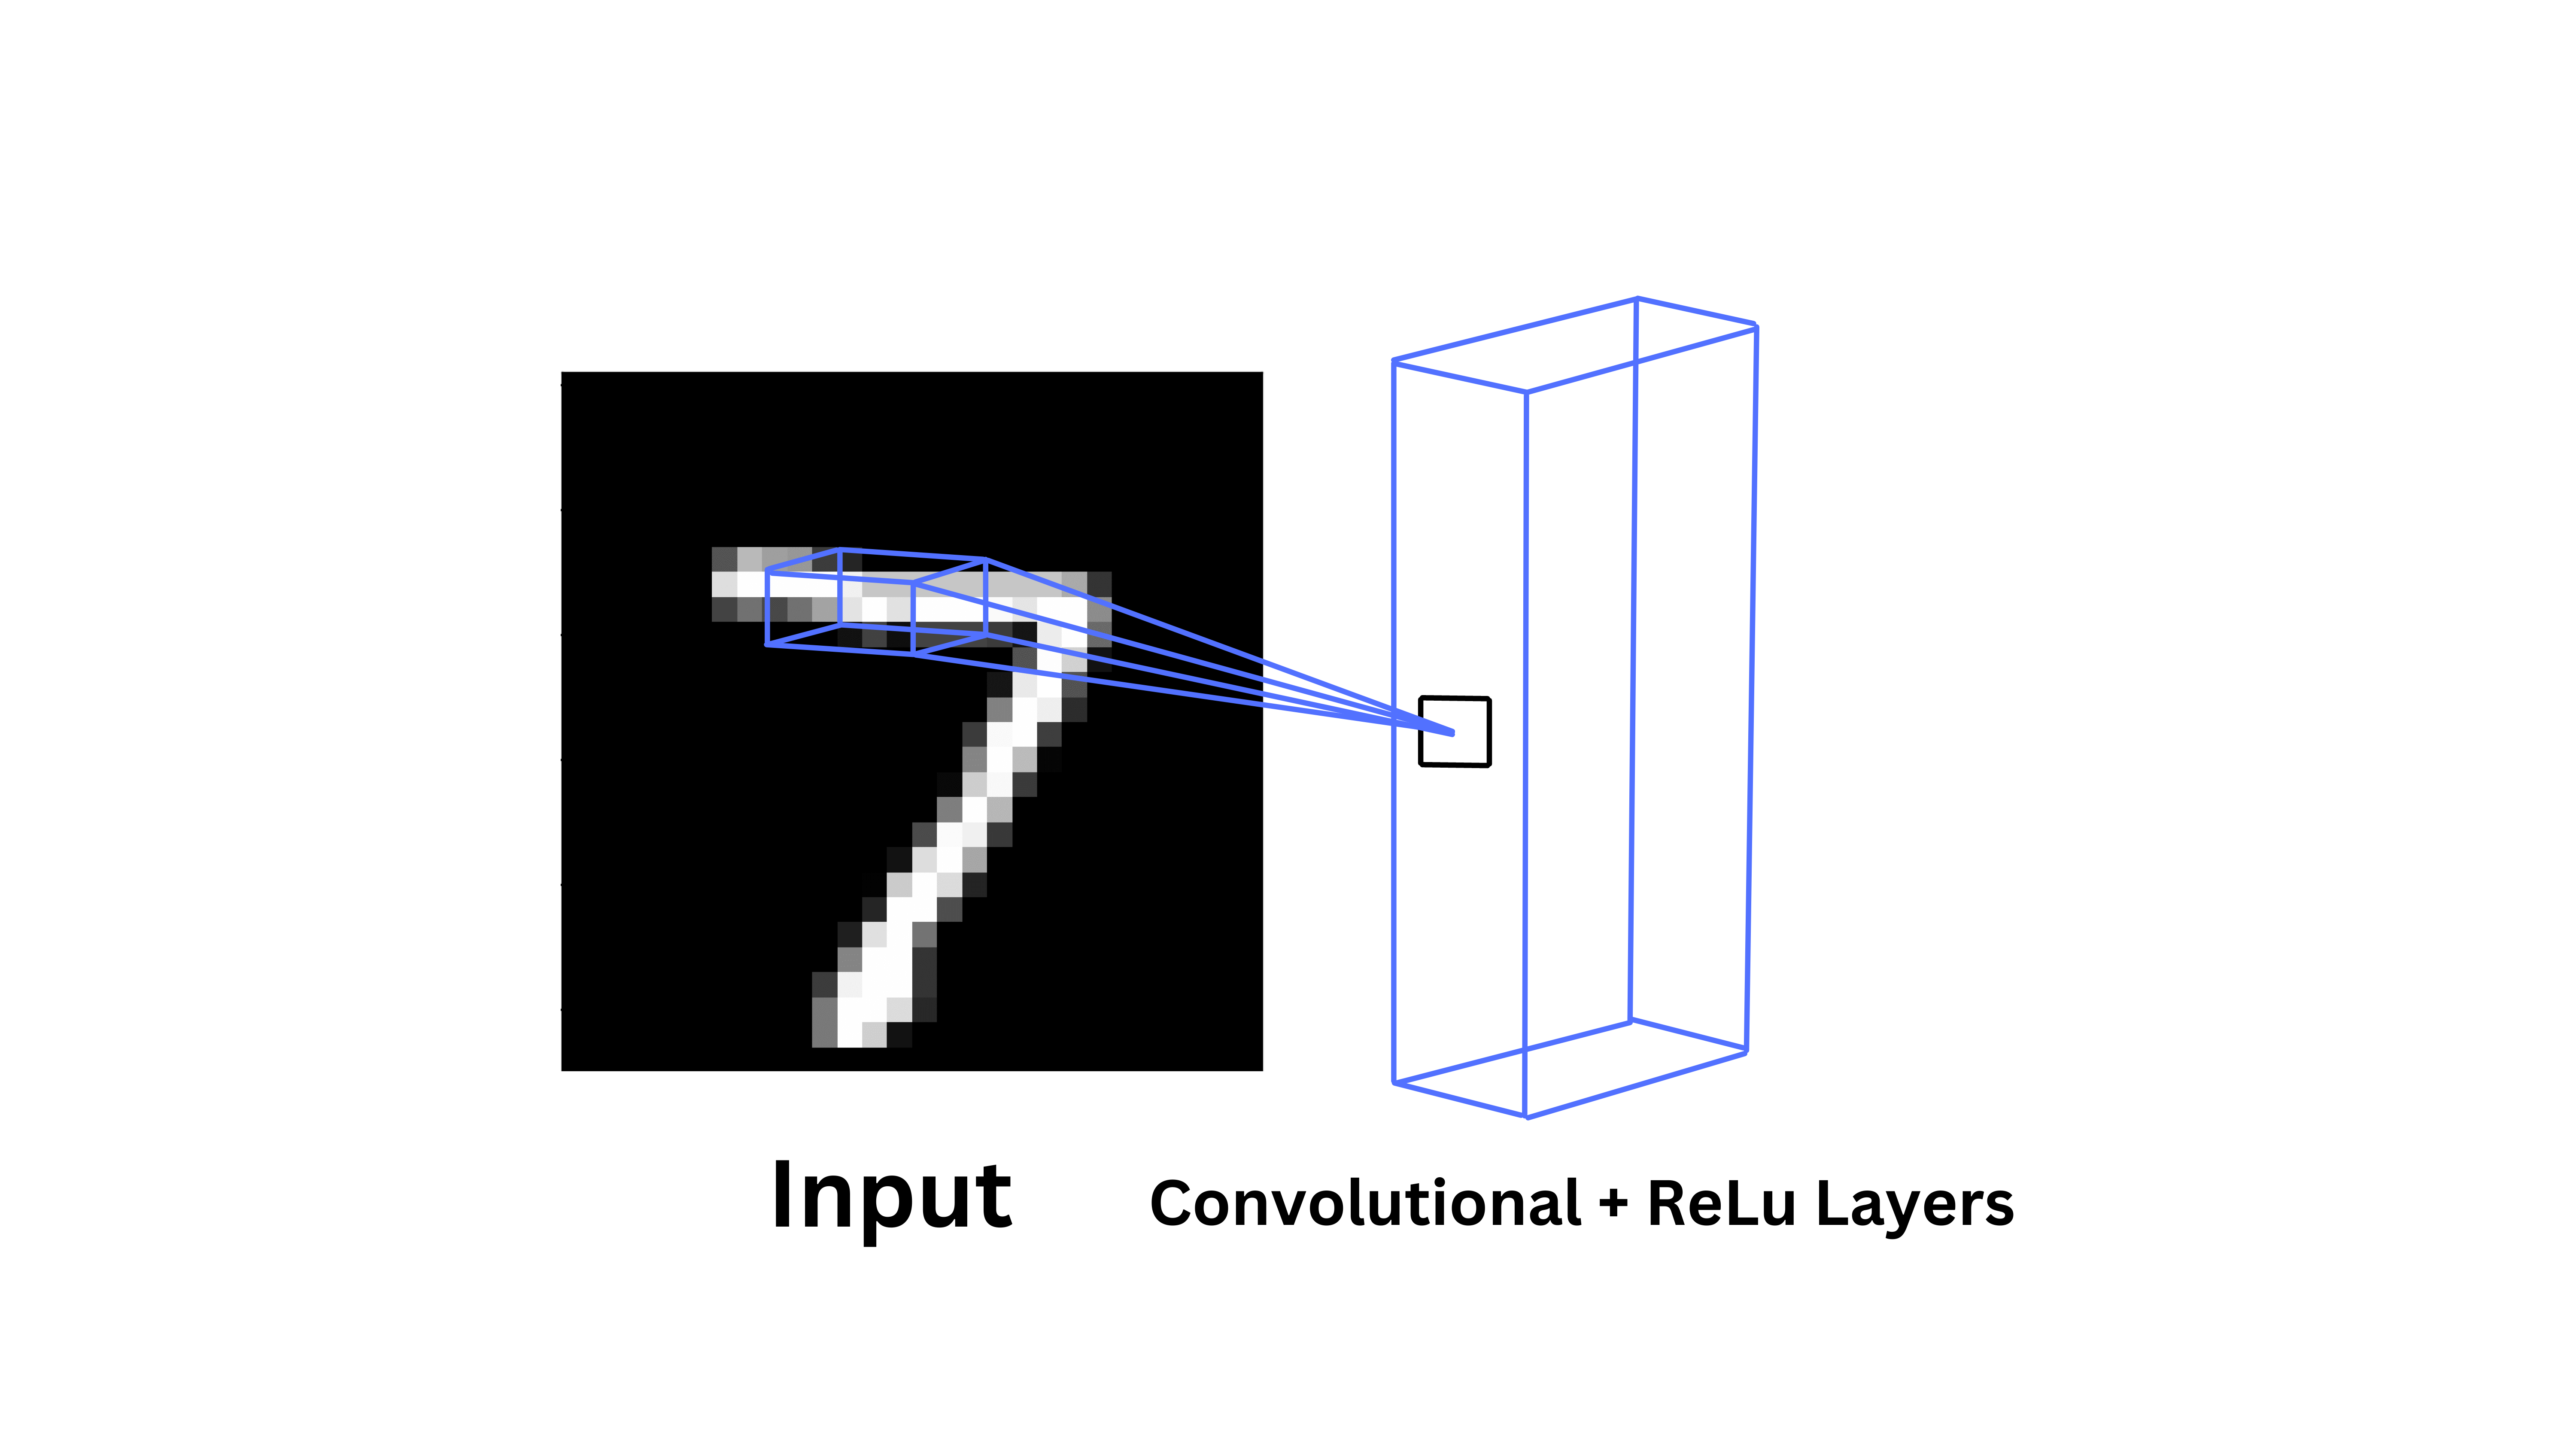

### Maxpool Layers:
- Runs a small filter over the input and chooses the max value in that filter region in that portion of the input.
- Helps reduce computation cost by reducing number of parameters (the input reduces by around a factor proportional to the size of the filter).

In [ ]:
F.max_pool2d

<function torch.nn.functional.boolean_dispatch.<locals>.fn(*args, **kwargs)>

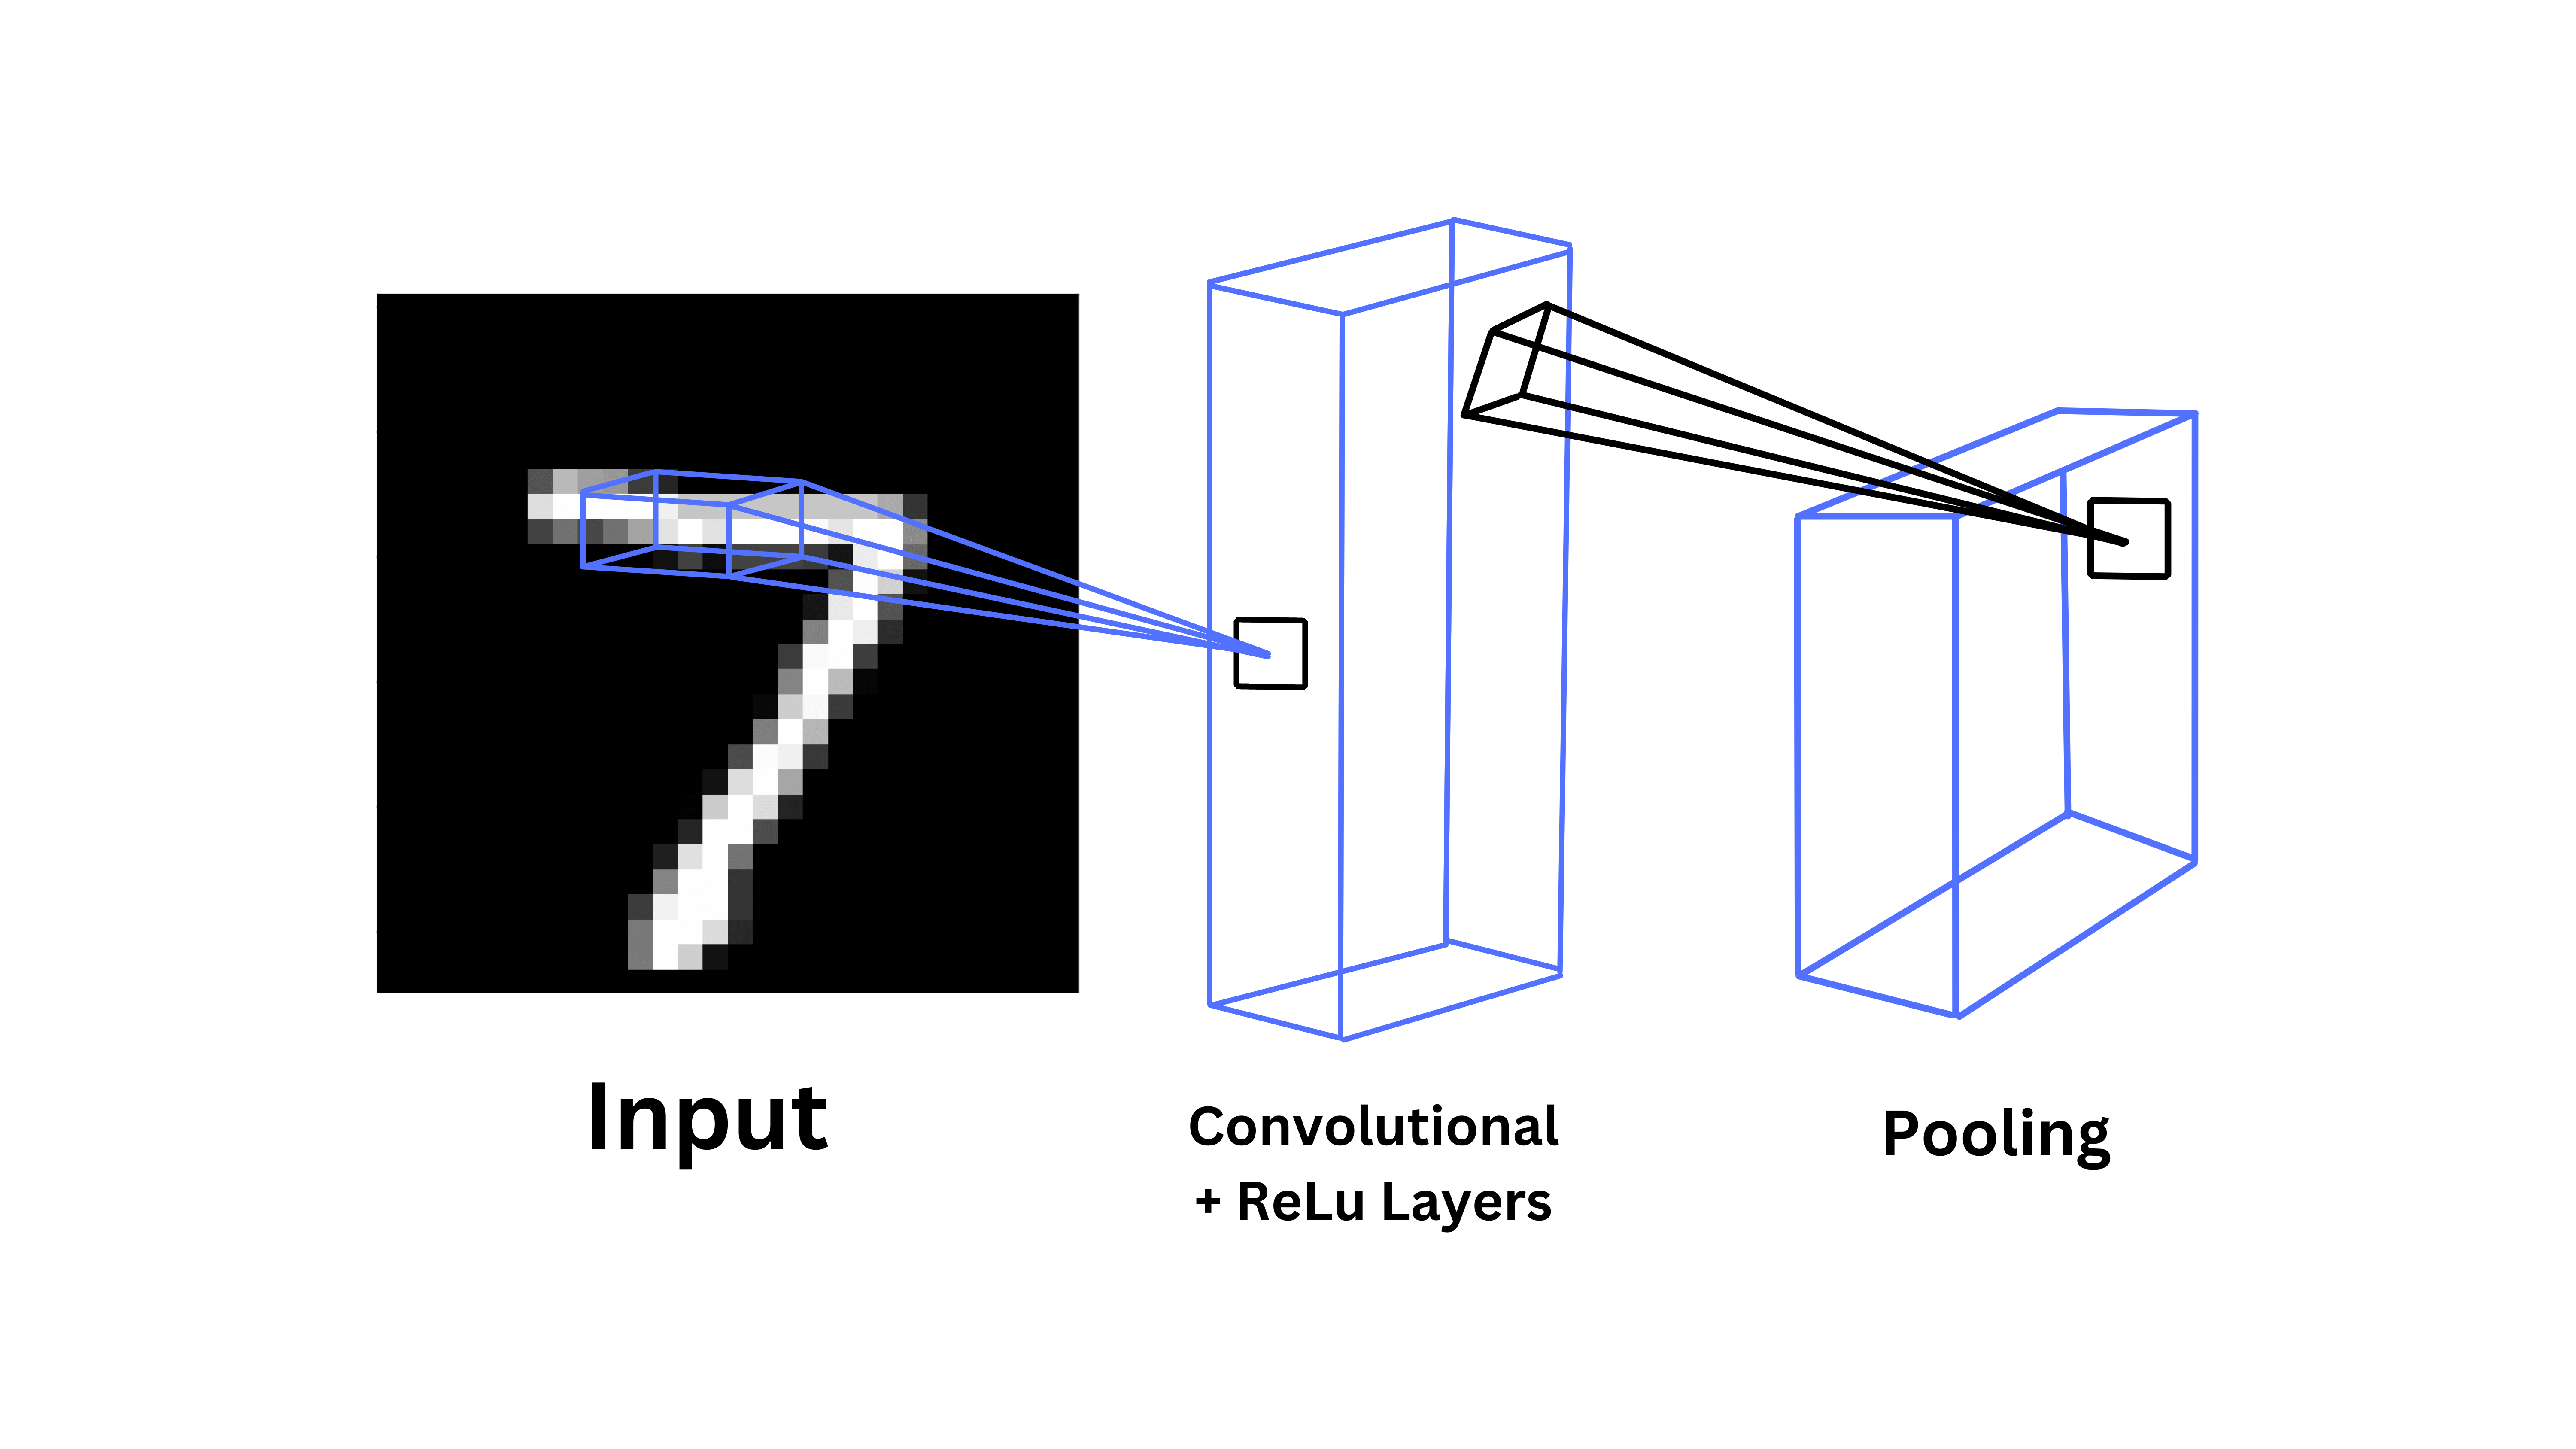

### Dropout Layers:
- Randomly set units in the input to 0.
- Help prevent overfitting to the training data.

❓ What is overfitting?

> Overfitting means that the model is quite accurate on training data but may have a difficult time providing accurate results for new data it has not seen/been trained on.

In [ ]:
nn.Dropout2d()

Dropout2d(p=0.5, inplace=False)

### Linear Layers:
- This is a normal Linear layer. Refer to Workshop 1 for more details.

In [ ]:
nn.Linear(50, 10)

Linear(in_features=50, out_features=10, bias=True)

### Log Softmax:
- Softmax cleverly uses the exponential function $e^x$ to convert any vector into a vector of probabilities all of whose elements sum to one. This is useful in classification tasks when you want to convert the output of a NN training on, for instance, MNIST into a vector of 10 values between 0 and 1. LogSoftmax is simply the natural log of this.

❓ How does softmax work?

> If the input vector is $\langle x_1, x_2, ..., x_n \rangle$, then softmax will output vector $\langle y_1, y_2, ..., y_n \rangle$ where $y_i = \frac{e^{x_i}}{\sum_{k=1}^{n} e^{x_k}}$. 

> Notice $\sum_{i=1}^{n} y_i = 1$.

In [ ]:
F.log_softmax

<function torch.nn.functional.log_softmax(input: torch.Tensor, dim: Union[int, NoneType] = None, _stacklevel: int = 3, dtype: Union[int, NoneType] = None) -> torch.Tensor>

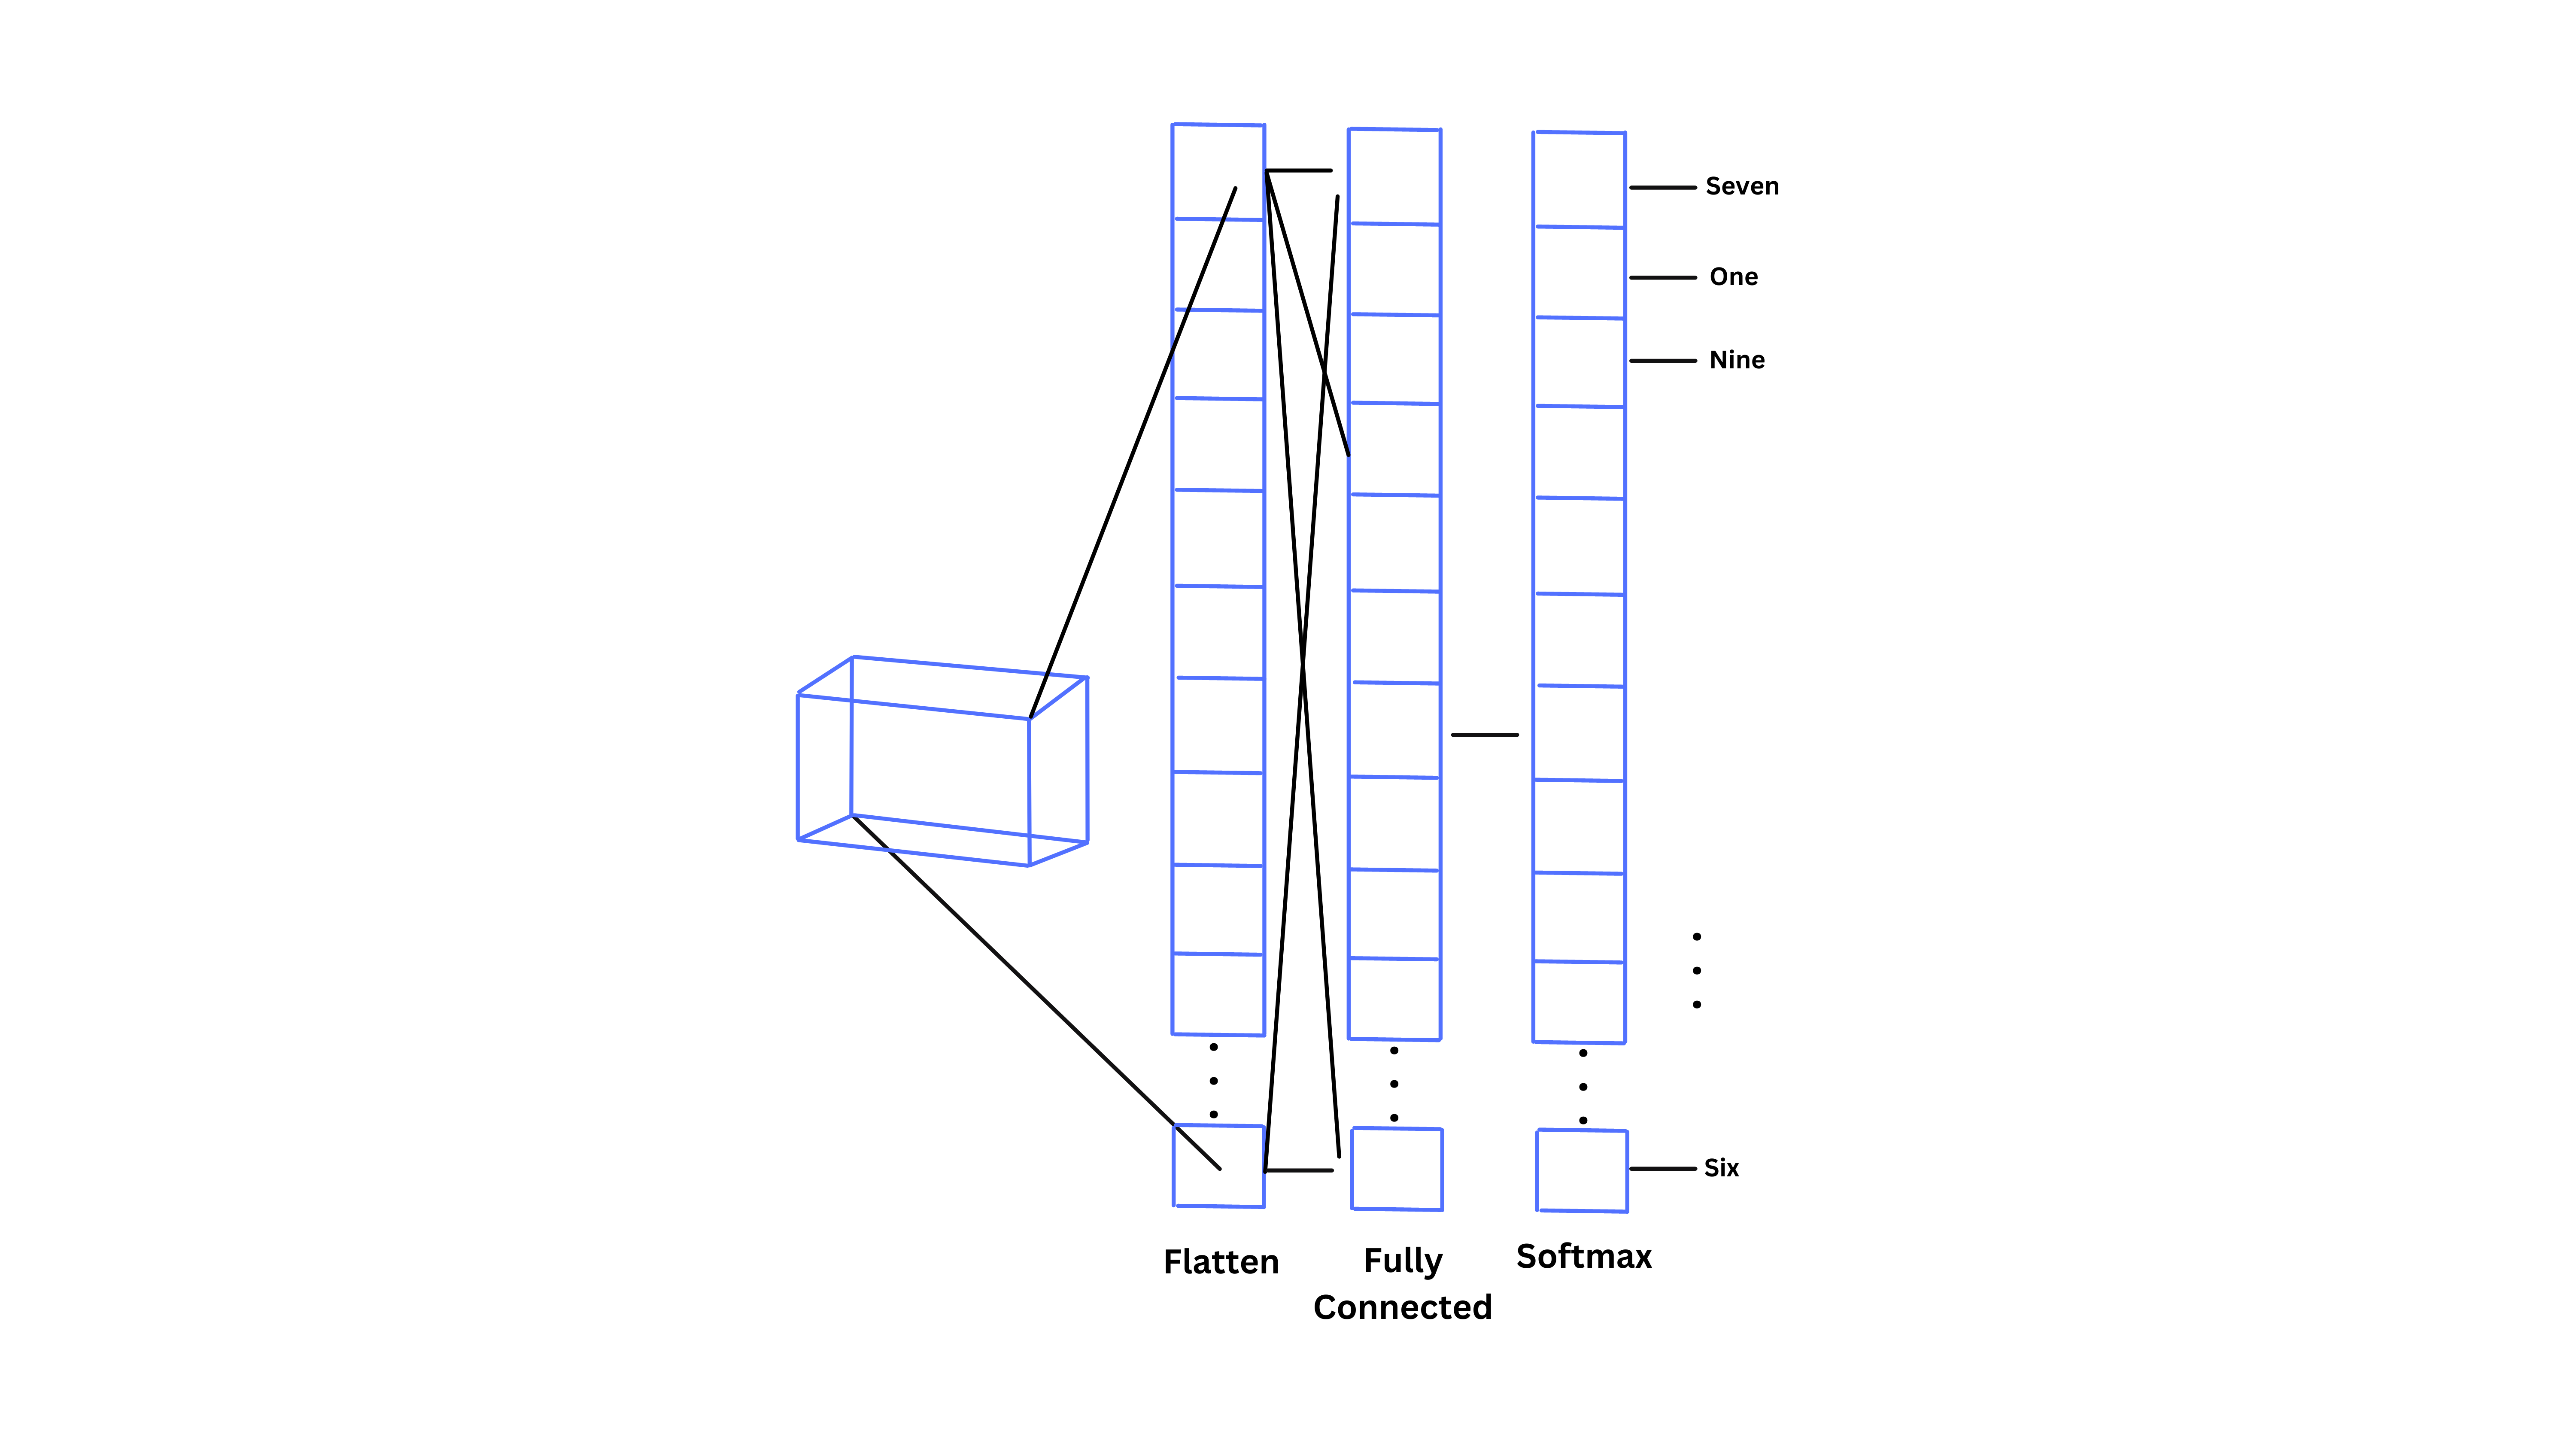

### If we put all parts of the CNN together, we get this model:

In [ ]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)#TODO, input is 10, output is 20
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.training) #TODO: F.dropout layer with x and self.training as parameters
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        #Softmax gets probabilities. 
        return F.log_softmax(x, dim=1)


❓ What is view?

> View takes the input data and returns the same data with new dimensions. The total number of elements cannot change.

❓ What does -1 mean in the view argument?

> When dealing with tensors, reshaping is useful. However, it is tedious to calculate all the dimensions. -1 indicates to torch that it should compute that dimension's size based on the information of the other specified dimensions and the shape of the input tensor. Note that you cannot pass more than one -1 in the argument else torch will give an exception since there would be more than one unknown variable.

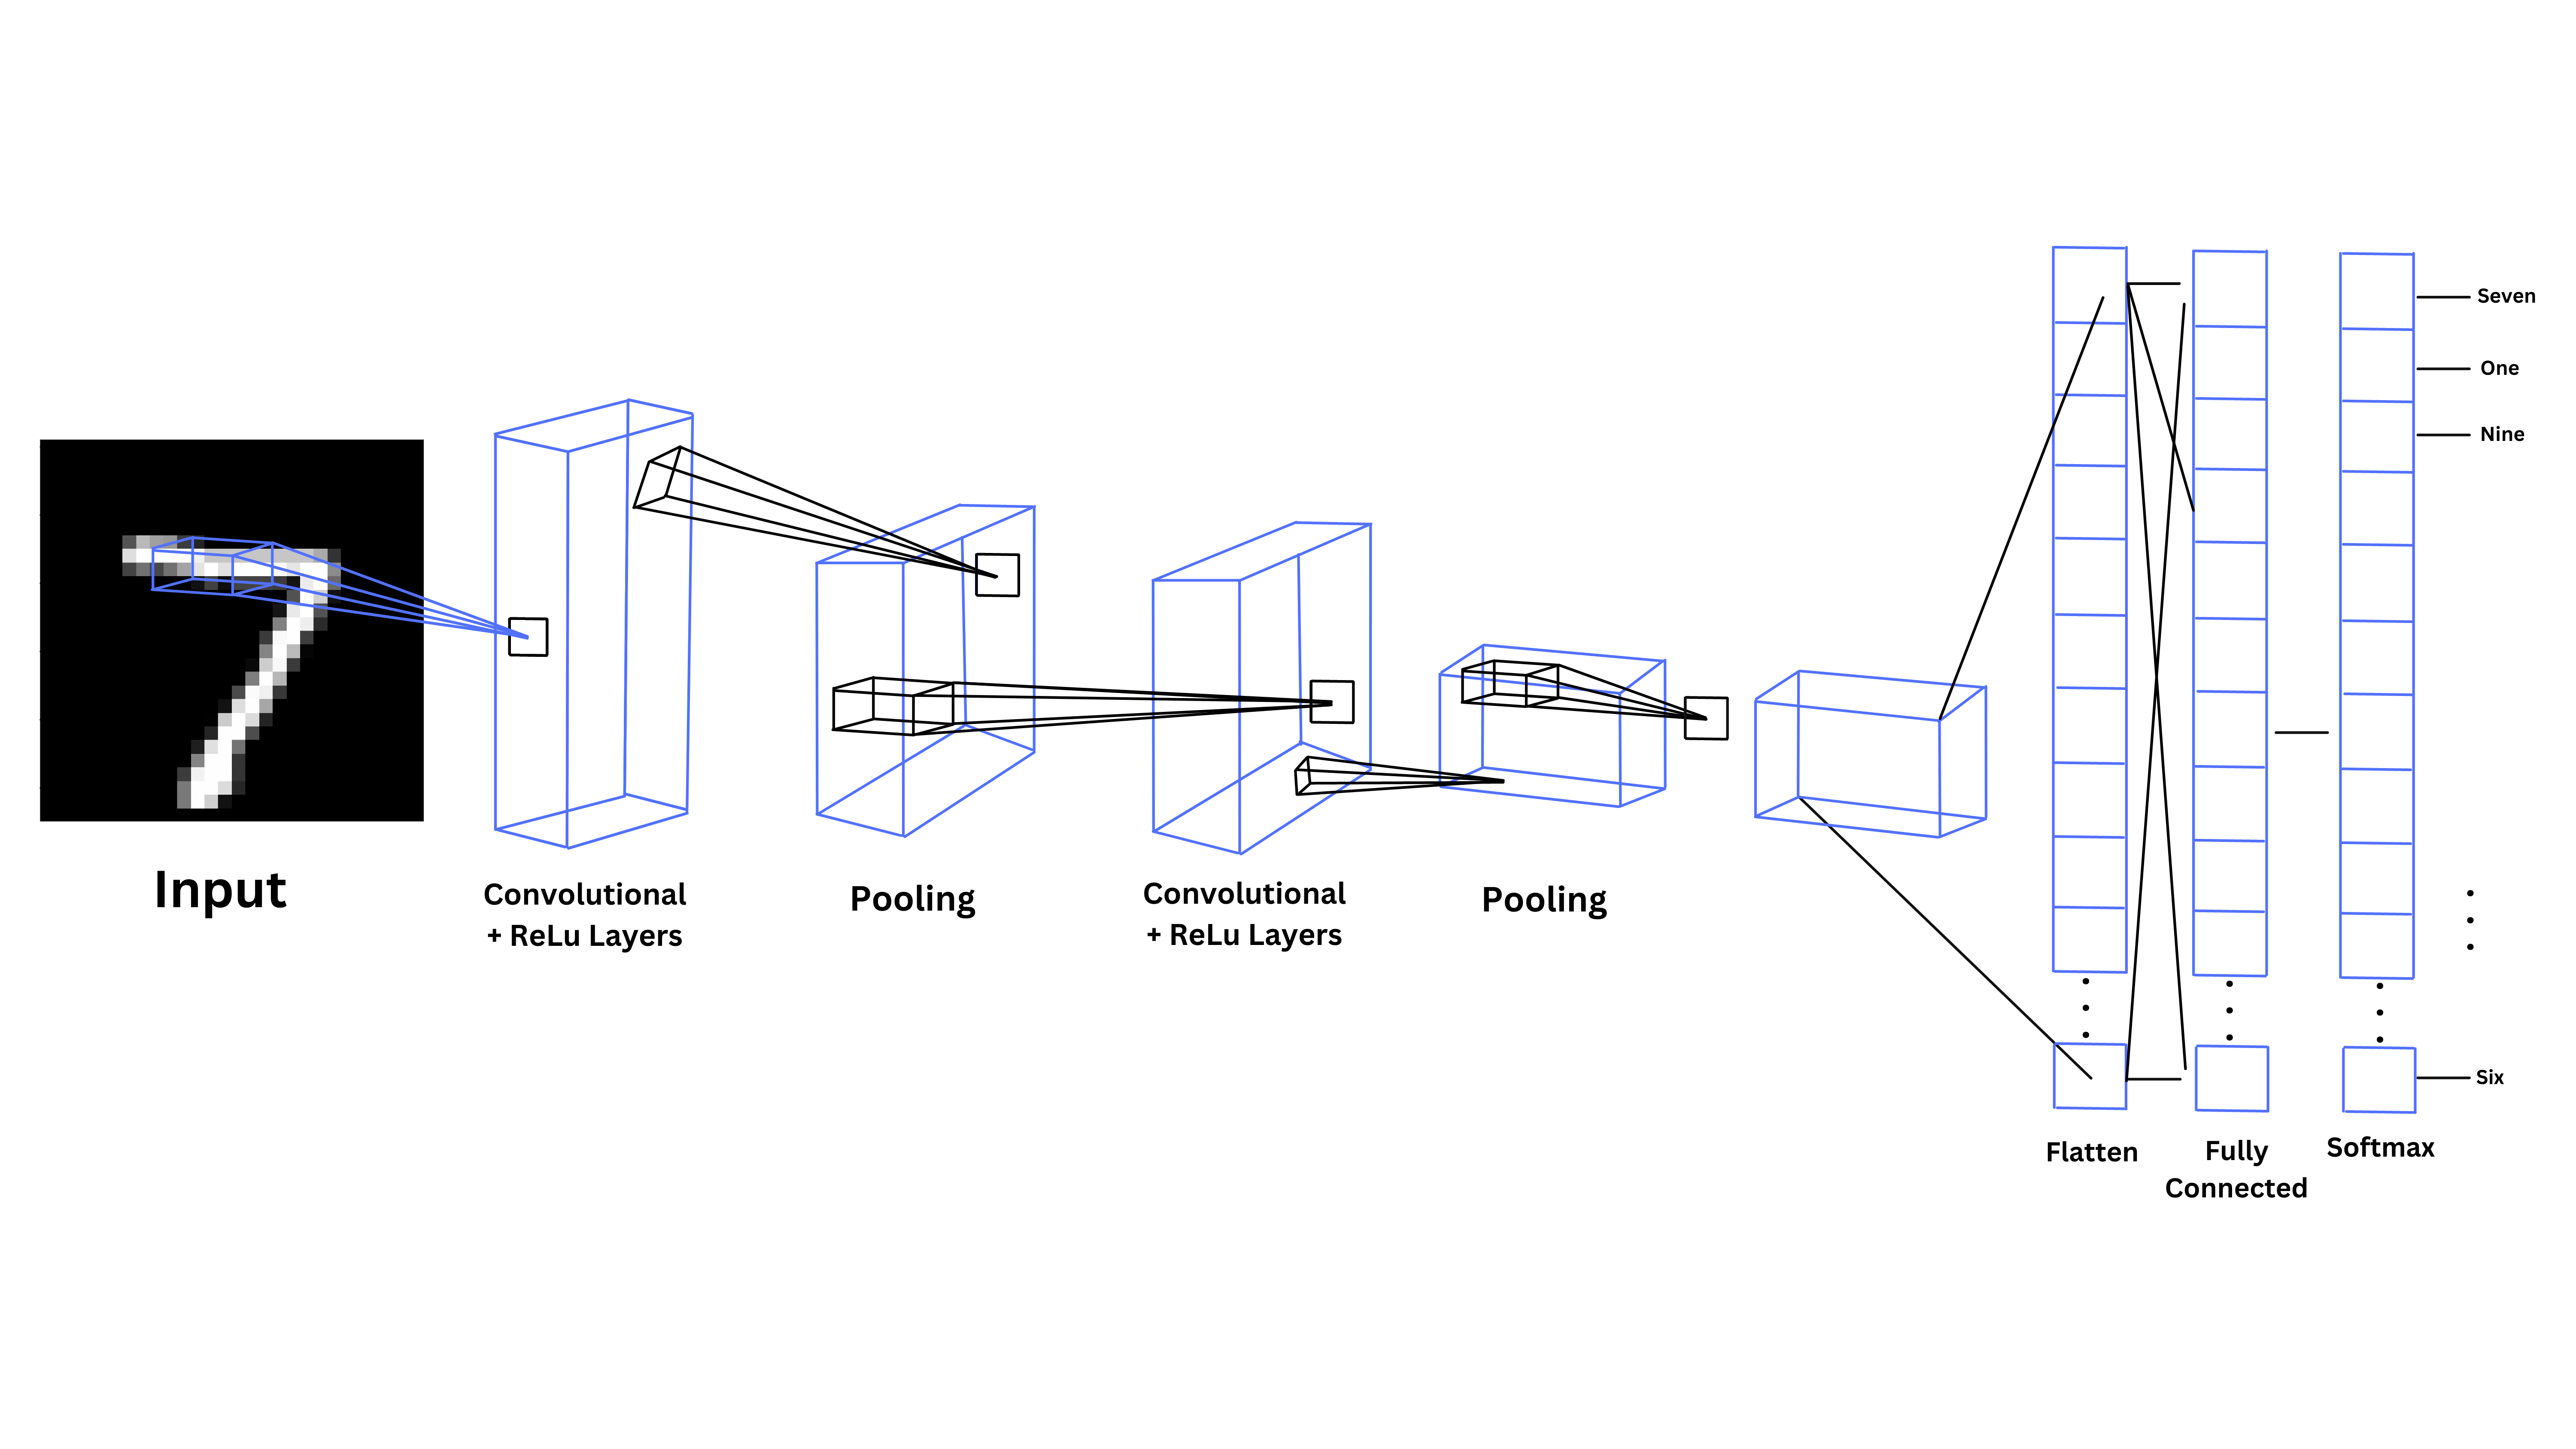

# 4. Training the Model

### How do we train a CNN?

> Now that we have created our NN architecture, we can train our model. It is similar to training an MLP based architecture: we extract our inputs and labels (data and target) from our dataset, reset our optimizer, run the model, compute the loss, and then backpropagate the loss with the help of the optimizer.

In [ ]:

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


### We can now evaluate our model by computing the loss on the test data:

In [ ]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


### Below we run the train and test functions:

In [ ]:
model = Net()


optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302109
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.304176
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.307156
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.307789
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.301941
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.300230


<ipython-input-7-ae3286c73093>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.2958, Accuracy: 982/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.304951
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.305735
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.305903
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.302844
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.303932
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.302217

Test set: Average loss: 2.2953, Accuracy: 964/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.303906
Train Epoch: 3 [10000/60000 (17%)]	Loss: 2.307174
Train Epoch: 3 [20000/60000 (33%)]	Loss: 2.303959
Train Epoch: 3 [30000/60000 (50%)]	Loss: 2.300592
Train Epoch: 3 [40000/60000 (67%)]	Loss: 2.304390
Train Epoch: 3 [50000/60000 (83%)]	Loss: 2.302316

Test set: Average loss: 2.2950, Accuracy: 997/10000 (10%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.302430
Train Epoch: 4 [10000/60000 (17%)]	Loss: 2.302839
Train Epoch: 4 [20000/60000 (33%)]	Loss: 2.303355
Train Epoch: 4 [30000/60000 (50%)]	Loss: 2.302226
Train Epoch: 4 [40000/60000 (67%)]	

# 5. Conclusion

To recap, here's what we did:

1. Downloaded and imported our libraries
2. Explained why CNN > MLP
3. Built our simple CNN model and trained it.

This notebook provided a small peek into the world of computer vision! We hope this notebook and our explanations sparked a little curiosity in you to explore other CV avenues. Much thanks to the credited people listed at the top of this notebook. We thank you for giving this code a look! 🙂